1. Load the Audio Data:

2. Segment the Waves: (S1, systolic, S2, diastolic)  

3. Resample or Align Segments: resample or time-align.

4. Calculate Deviations:

    - Amplitude difference 
    - Spectral analysis - spectrograms or Fourier transforms.
    - Statistical measures - mean, variance, etc.
5. Visualize the Deviations:

## Characteristic Heart sound
![S1-S2-S3-S4 Characteristic sound](Images\heart-sounds-S1-S2-S3-S4.png)

1. S1 (First Heart Sound):
    - Frequency range: Typically between 30 to 100 Hz.
    - Characteristics: S1 is the sound produced by the closure of the mitral and tricuspid valves.
    - It marks the start of systole (the contraction phase).
    - lub

2. S2 (Second Heart Sound):
    - Frequency range: Typically between 50 to 150 Hz.
    - Characteristics: S2 is produced by the closure of the aortic and pulmonary valves.
    - It marks the end of systole and the start of diastole (the relaxation phase).
    - dub

3. S3 and S4 (Additional Heart Sound):
    - S3 (occurring in early diastole): Frequency range of 20-60 Hz.
    - S4 (occurring in late diastole): Frequency range of 20-70 Hz.
    - These sounds are not always present in healthy individuals, but they may appear in certain pathological conditions.

4. Murmurs
    - Low-pitched murmurs: 80 to 400 Hz
    - High-pitched murmurs: 400 to 1000+ Hz
    - Abnormal heart sounds

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import resample

In [119]:
sr_normal, y_normal = wavfile.read('dataset/training_data/84813_AV.wav')
sr_abnormal, y_abnormal = wavfile.read('dataset/training_data/68419_AV.wav')

In [120]:
segments_normal = pd.read_csv('dataset/training_data/84813_AV.tsv', sep='\t', header=None)
segments_abnormal = pd.read_csv('dataset/training_data/68419_AV.tsv', sep='\t', header=None)

In [121]:
def extract_segments(audio, sr, segments):
    extracted_segments = []
    for _, row in segments.iterrows():
        start, end, label = row
        start_sample = int(start * sr)
        end_sample = int(end * sr)
        extracted_segments.append((label, audio[start_sample:end_sample]))
    return extracted_segments

In [122]:
normal_segments = extract_segments(y_normal, sr_normal, segments_normal)
abnormal_segments = extract_segments(y_abnormal, sr_abnormal, segments_abnormal)

In [123]:
def resample_segment(segment, target_length):
    return resample(segment, target_length)

def calculate_deviation(normal_seg, abnormal_seg):
    length = min(len(normal_seg), len(abnormal_seg))
    normal_resampled = resample_segment(normal_seg, length)
    abnormal_resampled = resample_segment(abnormal_seg, length)
    return normal_resampled - abnormal_resampled

def plot_segments(normal_seg, abnormal_seg, deviation, title, idx):
    plt.subplot(4, 2, idx)
    plt.plot(normal_seg, label='Normal', alpha=0.7)
    plt.plot(abnormal_seg, label='Abnormal', alpha=0.7)
    plt.plot(deviation, label='Deviation', linestyle='--')
    plt.title(title)
    # plt.legend()

### Plotting Original vs Resampled Signal

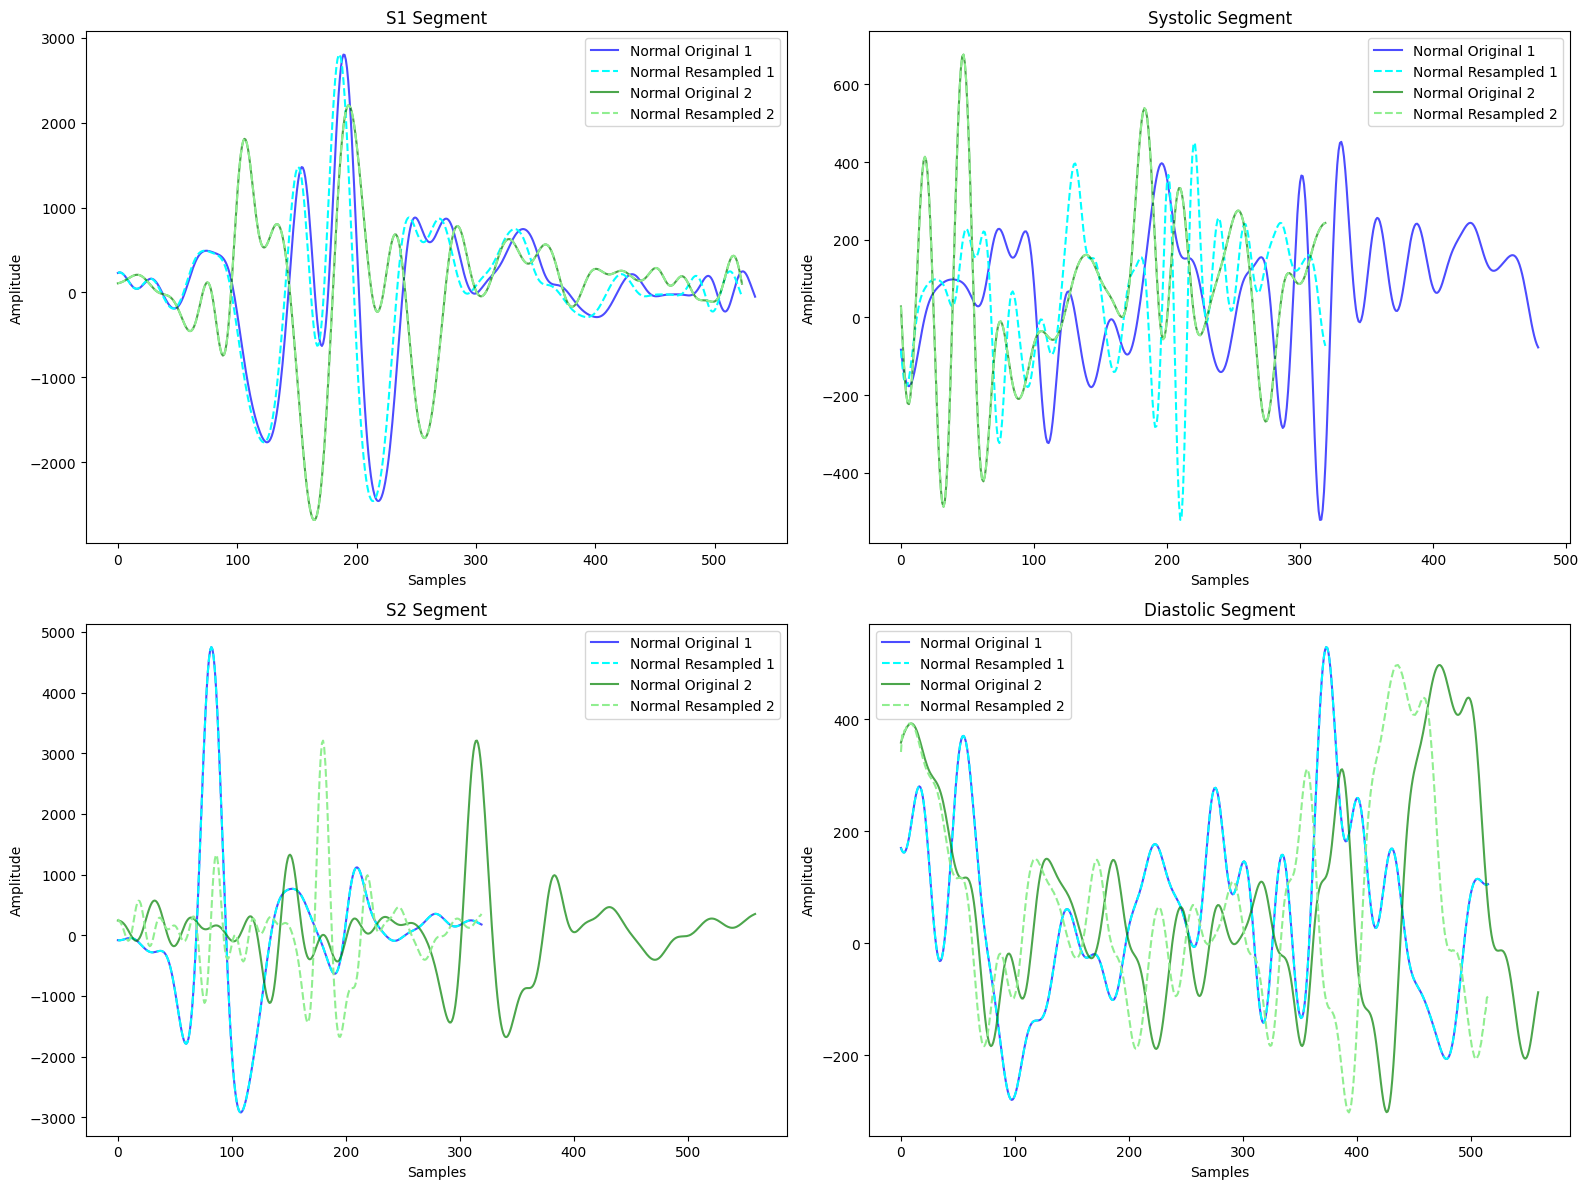

In [131]:
def plot_two_normal_vs_resampled(normal_seg1, resampled_normal1, normal_seg2, resampled_normal2, label, idx):
    plt.subplot(2, 2, idx)
    plt.plot(normal_seg1[:1000], label='Normal Original 1', alpha=0.7, color='blue')
    plt.plot(resampled_normal1[:1000], label='Normal Resampled 1', linestyle='--', color='cyan')
     
    plt.plot(normal_seg2[:1000], label='Normal Original 2', alpha=0.7, color='green')
    plt.plot(resampled_normal2[:1000], label='Normal Resampled 2', linestyle='--', color='lightgreen')

    plt.title(f'{label} Segment')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()

plt.figure(figsize=(16, 12))

labels = {1: 'S1', 2: 'Systolic', 3: 'S2', 4: 'Diastolic'}

for idx, label in enumerate(labels.keys(), start=1):
    normal_seg1 = next((seg[1] for seg in normal_segments if seg[0] == label), None)
    normal_seg2 = next((seg[1] for seg in normal_segments if seg[0] == label and not np.array_equal(seg[1], normal_seg1)), None)
    
    if normal_seg1 is not None and normal_seg2 is not None: 
        target_length = min(len(normal_seg1), len(normal_seg2)) 
        resampled_normal1 = resample_segment(normal_seg1, target_length)
        resampled_normal2 = resample_segment(normal_seg2, target_length)
        plot_two_normal_vs_resampled(normal_seg1, resampled_normal1, normal_seg2, resampled_normal2, labels[label], idx)

plt.tight_layout()
plt.show()


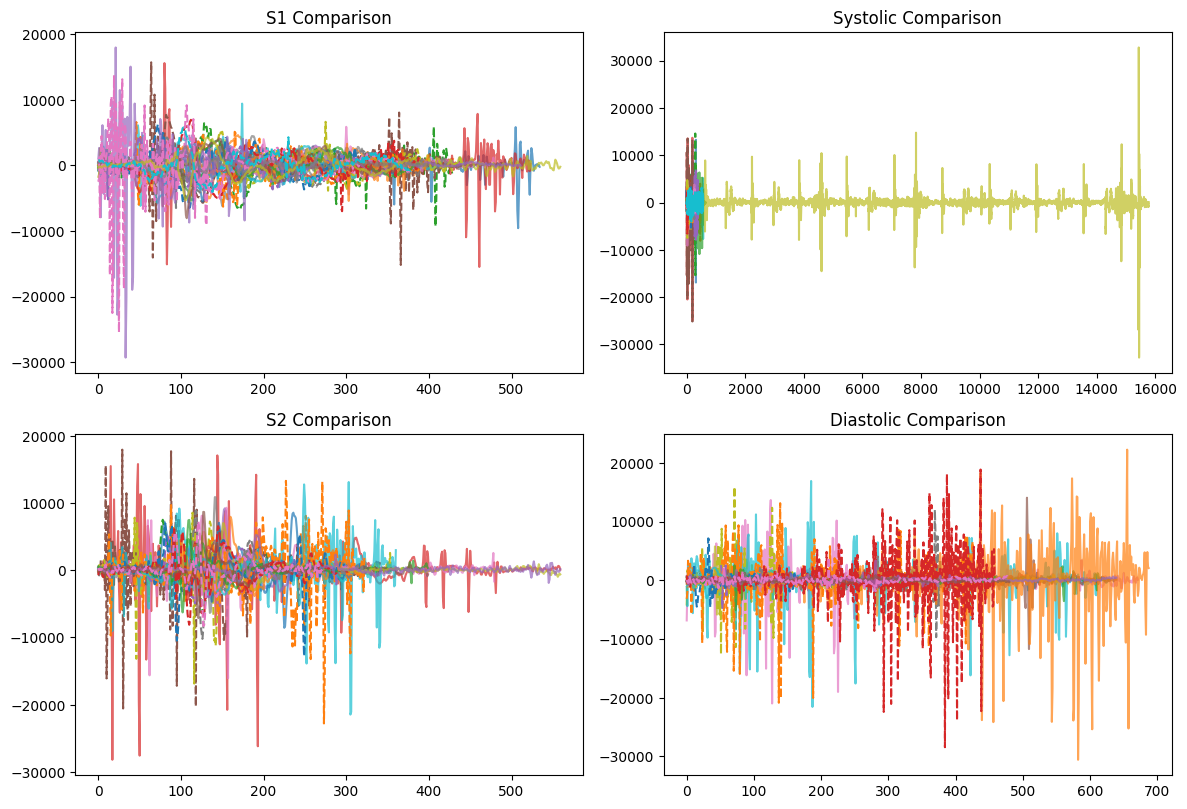

In [125]:
plt.figure(figsize=(12, 16))

for i, (normal_seg, abnormal_seg) in enumerate(zip(normal_segments, abnormal_segments)):
    label = normal_seg[0]
    if label in [1, 2, 3, 4]:
        normal_signal = normal_seg[1]
        abnormal_signal = abnormal_seg[1]
        deviation = calculate_deviation(normal_signal, abnormal_signal)
        
        if label == 1:
            plot_segments(normal_signal, abnormal_signal, deviation, 'S1 Comparison', 1)
        elif label == 2:
            plot_segments(normal_signal, abnormal_signal, deviation, 'Systolic Comparison', 2)
        elif label == 3:
            plot_segments(normal_signal, abnormal_signal, deviation, 'S2 Comparison', 3)
        elif label == 4:
            plot_segments(normal_signal, abnormal_signal, deviation, 'Diastolic Comparison', 4)

plt.tight_layout()
plt.show()

In [126]:
def gather_segments_by_type(segments, segment_type):
    segment_list = []
    for label, segment in segments:
        if label == segment_type:
            segment_list.append(segment)
    return segment_list

def resample_all_segments(segment_list, target_length):
    resampled_segments = [resample_segment(seg, target_length) for seg in segment_list]
    return np.array(resampled_segments)
 
def plot_mean_segments(normal_mean, abnormal_mean, label):
    plt.figure(figsize=(12, 6))
     
    plt.plot(normal_mean[:200], label='Normal Mean', color='blue', alpha=0.7)
    plt.plot(abnormal_mean[:200], label='Abnormal Mean', color='red', linestyle='--', alpha=0.7)
    
    plt.title(f'Mean {label}')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
     
    plt.show() 


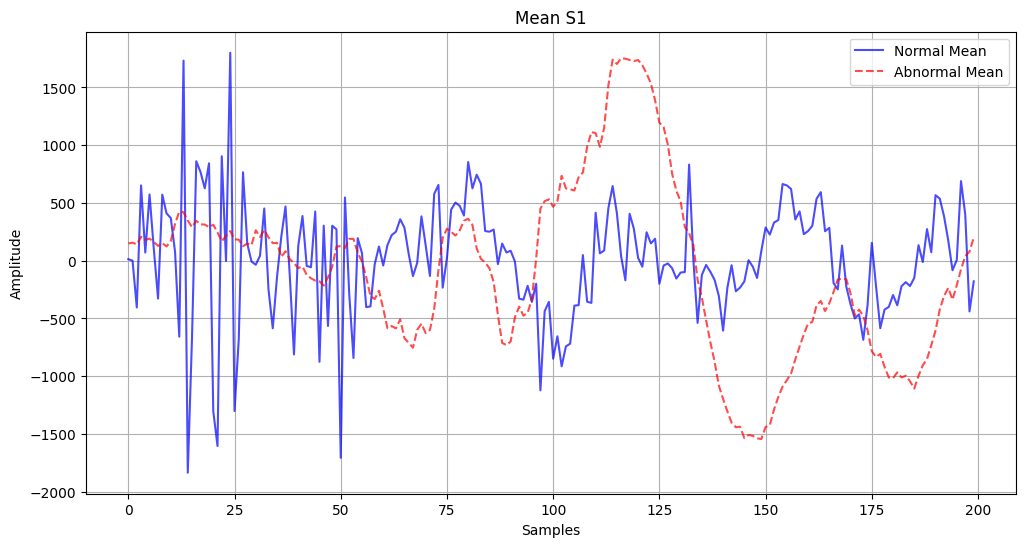

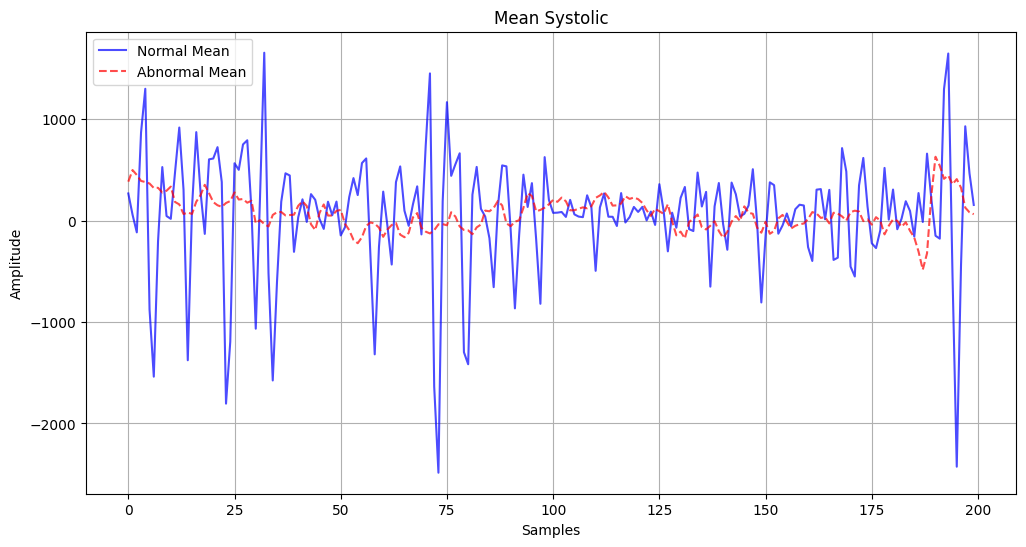

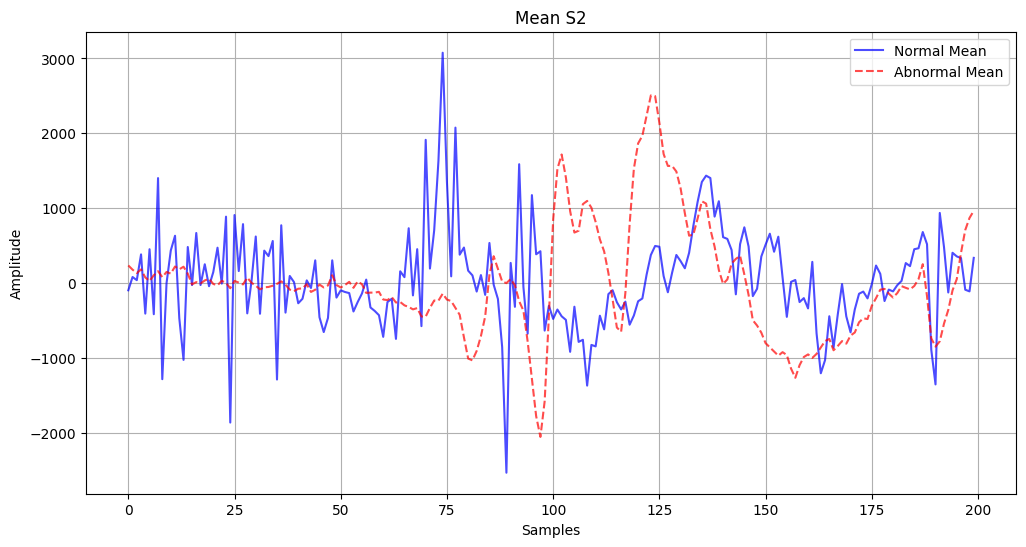

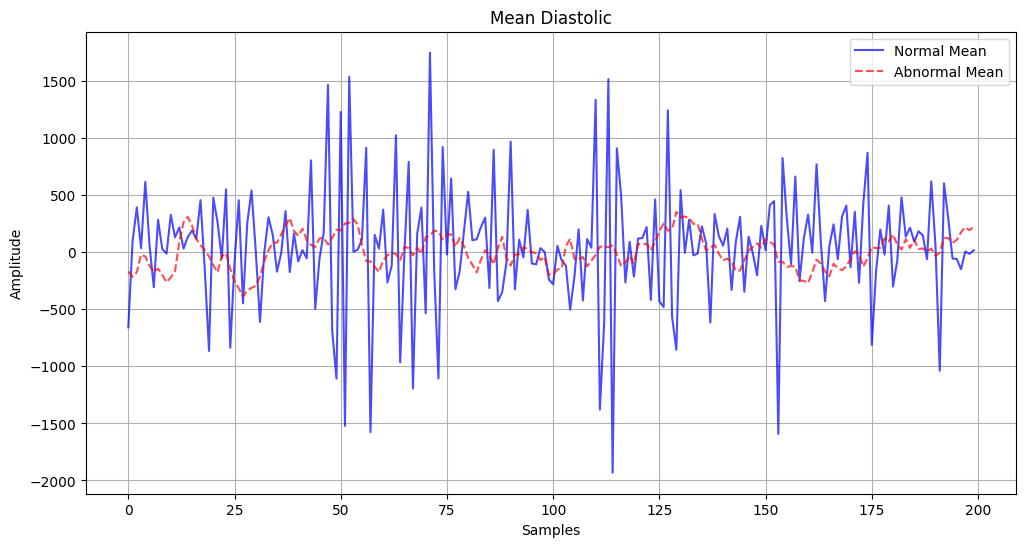

<Figure size 640x480 with 0 Axes>

In [127]:
segment_types = {'S1': 1, 'Systolic': 2, 'S2': 3, 'Diastolic': 4}

for segment_name, segment_type in segment_types.items(): 
    normal_segment_list = gather_segments_by_type(normal_segments, segment_type)
    abnormal_segment_list = gather_segments_by_type(abnormal_segments, segment_type)
    min_length = min(min(len(seg) for seg in normal_segment_list),
                     min(len(seg) for seg in abnormal_segment_list))
    
    resampled_normal_segments = resample_all_segments(normal_segment_list, min_length)
    resampled_abnormal_segments = resample_all_segments(abnormal_segment_list, min_length)
    normal_mean = np.mean(resampled_normal_segments, axis=0)
    abnormal_mean = np.mean(resampled_abnormal_segments, axis=0)
    plot_mean_segments(normal_mean, abnormal_mean, segment_name)

plt.tight_layout()
plt.show()


In [128]:
from scipy.signal import butter, filtfilt
def butterworth_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def extract_and_filter_segments(audio, sr, segments, cutoff):
    extracted_segments = []
    filtered_audio = butterworth_filter(audio, cutoff=cutoff, fs=sr) 
    
    for _, row in segments.iterrows():
        start, end, label = row
        start_sample = int(start * sr)
        end_sample = int(end * sr)
        extracted_segments.append((label, filtered_audio[start_sample:end_sample]))
    
    return extracted_segments

In [129]:
cutoff_frequency = 150
normal_segments = extract_and_filter_segments(y_normal, sr_normal, segments_normal, cutoff=cutoff_frequency)
abnormal_segments = extract_and_filter_segments(y_abnormal, sr_abnormal, segments_abnormal, cutoff=cutoff_frequency)

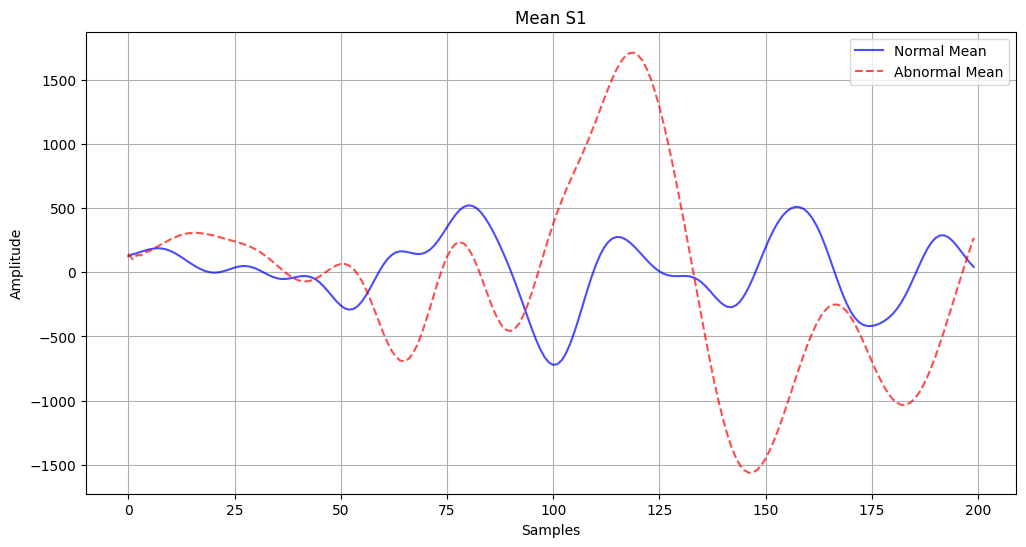

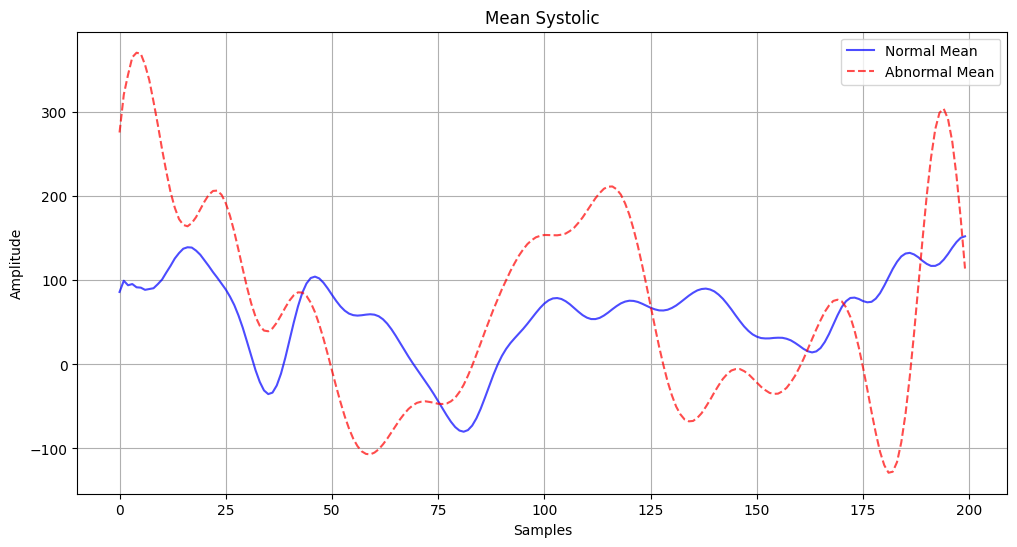

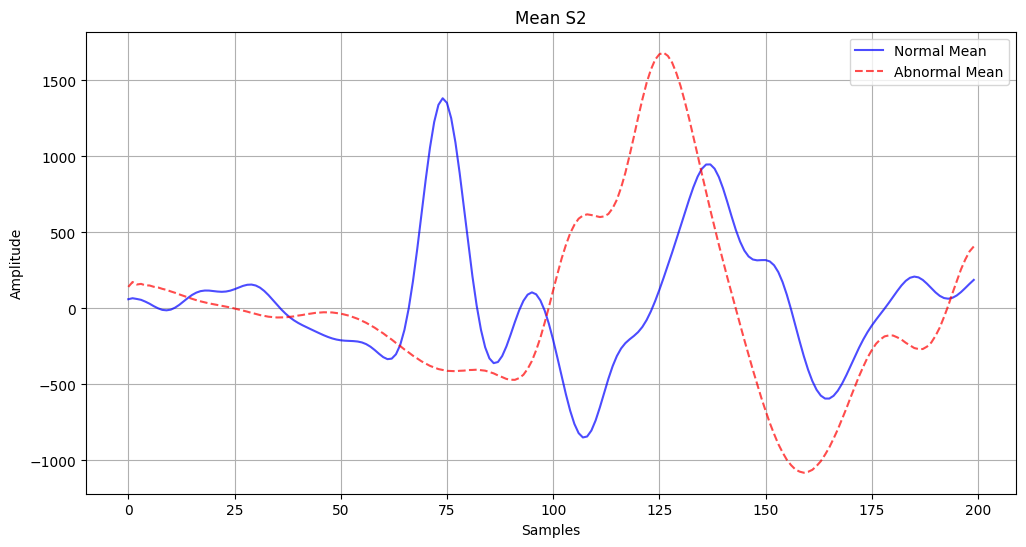

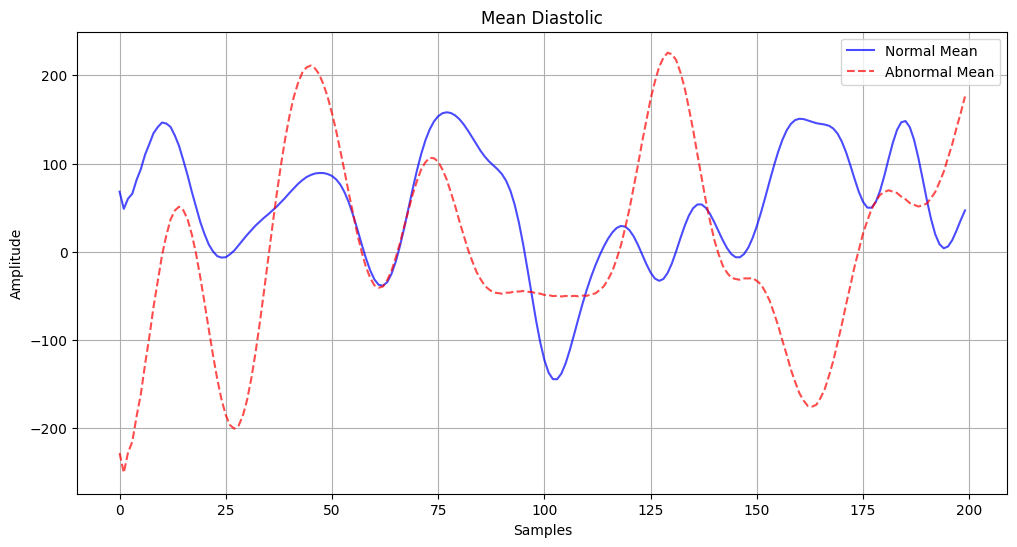

In [130]:
for segment_name, segment_type in segment_types.items(): 
    normal_segment_list = gather_segments_by_type(normal_segments, segment_type)
    abnormal_segment_list = gather_segments_by_type(abnormal_segments, segment_type)
     
    min_length = min(min(len(seg) for seg in normal_segment_list),
                     min(len(seg) for seg in abnormal_segment_list))
    
    resampled_normal_segments = resample_all_segments(normal_segment_list, min_length)
    resampled_abnormal_segments = resample_all_segments(abnormal_segment_list, min_length)
     
    normal_mean = np.mean(resampled_normal_segments, axis=0)
    abnormal_mean = np.mean(resampled_abnormal_segments, axis=0)
     
    plot_mean_segments(normal_mean, abnormal_mean, segment_name)